<a href="https://colab.research.google.com/github/IjeomaM/dotnet-project/blob/main/IjeomaMaduka23624032_DeepLearning_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Import Packages



In [5]:
# Import necessary packages.
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset

import torchvision
from torchvision import datasets
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms

# This is for the progress bar
from tqdm.auto import tqdm
# This is for ploting
import matplotlib.pyplot as plt

# 2 Dataset

## 2.1 Download the Food-11 Dataset

In [1]:
# Install a package to download data from Kaggle
!pip install -q opendatasets

In [2]:
import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/trolukovich/food11-image-dataset/')


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ijeomamaduka
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/trolukovich/food11-image-dataset


100%|██████████| 1.08G/1.08G [00:51<00:00, 22.6MB/s]


## 2.2 PyTorch Dataset and Dataloader

In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(degrees=10),  # Randomly rotate the image by a maximum of 10 degrees
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # Adjust color brightness, contrast, and saturation
    transforms.Resize((224, 224)),  # Resize the image to a fixed shape (height = width = 224)
    # Additional transforms can be added here
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a fixed shape (height = width = 224)
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])


In [7]:
# Construct datasets.
train_dataset = datasets.ImageFolder("/content/food11-image-dataset/training", transform=train_transform)
validation_dataset = datasets.ImageFolder("/content/food11-image-dataset/validation", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/food11-image-dataset/evaluation", transform=test_transform)




print(f'Train set has {len(train_dataset)} samples')
print(f'Validation set has {len(validation_dataset)} samples')
print(f'Test set has {len(test_dataset)} samples')

Train set has 9866 samples
Validation set has 3430 samples
Test set has 3347 samples


In [8]:
# Batch size for training, validation, and testing.
# But the GPU memory is limited, so please adjust it carefully.
batch_size = 32

# Construct data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

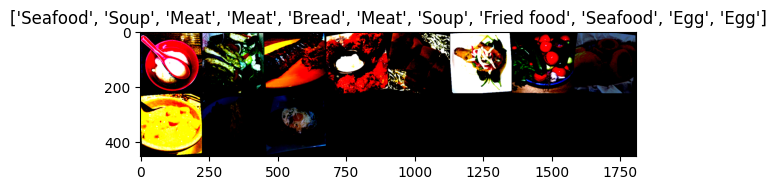

In [ ]:
# show some samples
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
train_loader_for_vis = DataLoader(train_dataset, batch_size=11, shuffle=True, num_workers=0)
inputs, classes = next(iter(train_loader_for_vis))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

class_names = ['Bread', 'Dairy products', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Seafood', 'Soup', 'Vegetable-Fruit']

imshow(out, title=[class_names[x] for x in classes])

# 3 Model -CNN

In [ ]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # The arguments for commonly used modules:
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)

        # input image size: [3, 224, 224]
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),

            nn.Conv2d(128, 256, 3, 1, 1), # TODO: set a convolution layer with out_channels=256, kernel_size=3, stride=1, padding=1
            nn.ReLU(),
            nn.MaxPool2d(4, 4, 0), # TODO: set a max pooling layer with kernel_size=4, stride=4, padding=0
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*14*14, 256), # TODO: fill in the correct input feature size after flatten. The tensor shape before flatten is (256, 14, 14)
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 7]

        # Extract features by convolutional layers.
        x = self.cnn_layers(x)

        # The extracted feature map must be flatten before going to fully-connected layers.
        x = x.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        x = self.fc_layers(x)
        return x

In [ ]:
# "cuda" only when GPUs are available and define the device.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize a model, and put it on the device specified.
cnnmodel = MyCNN()
cnnmodel = cnnmodel.to(device)

# 4 Define Loss and Optimizer

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(cnnmodel.parameters(), lr=0.0003)

# 5 Train and Validation

In [ ]:


# The number of training epochs.
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    cnnmodel.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = cnnmodel(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    cnnmodel.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = cnnmodel(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(cnnmodel.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")

  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=2.06079, acc=0.27828 | Valid: loss=1.91977, acc=0.32359


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=1.82578, acc=0.35787 | Valid: loss=1.72010, acc=0.39680


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=1.61538, acc=0.44280 | Valid: loss=1.61433, acc=0.44763


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=1.44314, acc=0.50309 | Valid: loss=1.54485, acc=0.46875


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=1.29602, acc=0.55736 | Valid: loss=1.39201, acc=0.52566


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=1.18995, acc=0.59102 | Valid: loss=1.36852, acc=0.53954


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=1.08106, acc=0.62690 | Valid: loss=1.38600, acc=0.53077


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=0.97579, acc=0.66756 | Valid: loss=1.35635, acc=0.54871


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=0.88080, acc=0.70051 | Valid: loss=1.33988, acc=0.55507


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=0.78821, acc=0.73412 | Valid: loss=1.35254, acc=0.54958


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=0.69886, acc=0.75995 | Valid: loss=1.37928, acc=0.57427


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=0.62079, acc=0.79005 | Valid: loss=1.49569, acc=0.57388


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=0.56077, acc=0.80821 | Valid: loss=1.51948, acc=0.57639


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=0.49741, acc=0.83192 | Valid: loss=1.51725, acc=0.56154


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=0.44122, acc=0.84842 | Valid: loss=1.63489, acc=0.56559


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=0.39231, acc=0.86640 | Valid: loss=1.79654, acc=0.54061


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=0.33784, acc=0.88926 | Valid: loss=1.80653, acc=0.57205


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=0.29680, acc=0.90299 | Valid: loss=1.78685, acc=0.57880


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=0.27119, acc=0.90744 | Valid: loss=1.96101, acc=0.57128


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=0.25275, acc=0.91511 | Valid: loss=1.84245, acc=0.58661


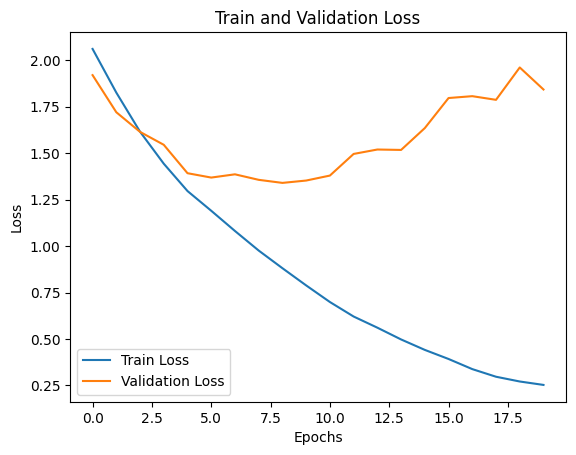

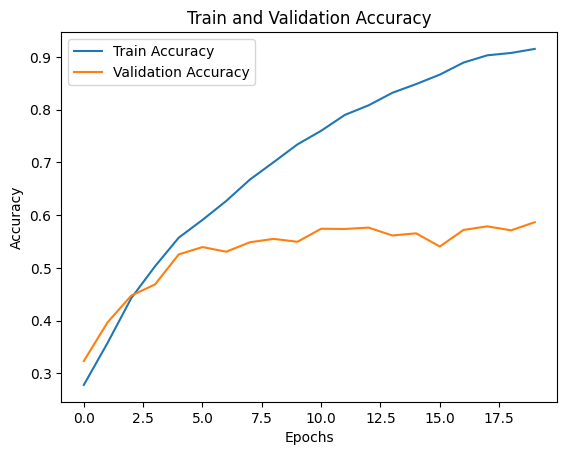

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

3 Model -RESNET18

In [ ]:

import torchvision.models as models

class MyRESNET(nn.Module):
    def __init__(self):
        super(MyRESNET, self).__init__()
        # Load pre-trained RESNET18 model
        resnet18 = models.resnet18(pretrained=True)

        # Remove the final fully connected layer from RESNET18
        self.features = nn.Sequential(*list(resnet18.children())[:-1])

        # Define additional fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512, 256),  # Adjust the input size based on the output size of RESNET18
            nn.ReLU(),
            nn.Linear(256, 11)    # Output size 11 for classification
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 11] for 11 classes

        # Extract features using RESNET18
        x = self.features(x)

        # Flatten the extracted features
        x = torch.flatten(x, 1)

        # Pass through additional fully connected layers
        x = self.fc_layers(x)
        return x




In [ ]:
# Load pretrained ResNet18 model
RESNET_model = models.resnet18(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_ftrs = RESNET_model.fc.in_features
RESNET_model.fc = nn.Linear(num_ftrs, 11)  # Assuming there are 11 classes

# Check if CUDA (GPU) is available and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create an instance of the MyRESNET model
RESNET_model.to(device)

# Define loss function and optimizer # Initialize optimizer, define loss function using the learning rate of 0.0003.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET_model.parameters(), lr=0.0003)

# Number of training epochs
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    RESNET_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = RESNET_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    RESNET_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = RESNET_model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(RESNET_model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=0.70641, acc=0.76952 | Valid: loss=0.56705, acc=0.81154


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=0.32893, acc=0.89045 | Valid: loss=0.64691, acc=0.79688


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=0.17877, acc=0.94221 | Valid: loss=0.75904, acc=0.77797


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=0.16010, acc=0.94903 | Valid: loss=0.64844, acc=0.81395


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=0.09569, acc=0.96855 | Valid: loss=0.83877, acc=0.81096


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=0.11702, acc=0.96046 | Valid: loss=0.64292, acc=0.83700


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=0.07937, acc=0.97542 | Valid: loss=0.61757, acc=0.84578


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=0.08011, acc=0.97559 | Valid: loss=0.72312, acc=0.82166


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=0.08662, acc=0.97158 | Valid: loss=0.71271, acc=0.82147


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=0.04853, acc=0.98301 | Valid: loss=0.65412, acc=0.84886


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=0.05515, acc=0.98402 | Valid: loss=0.71397, acc=0.82485


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=0.07329, acc=0.97751 | Valid: loss=0.88843, acc=0.79263


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=0.07782, acc=0.97593 | Valid: loss=0.69668, acc=0.82523


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=0.05798, acc=0.98125 | Valid: loss=0.69669, acc=0.83131


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=0.05411, acc=0.98240 | Valid: loss=0.72482, acc=0.83353


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=0.03526, acc=0.98946 | Valid: loss=0.85399, acc=0.82369


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=0.07090, acc=0.97591 | Valid: loss=0.68572, acc=0.83787


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=0.04385, acc=0.98523 | Valid: loss=0.91923, acc=0.81877


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=0.04256, acc=0.98797 | Valid: loss=0.80557, acc=0.81356


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=0.02852, acc=0.99039 | Valid: loss=0.77433, acc=0.83102


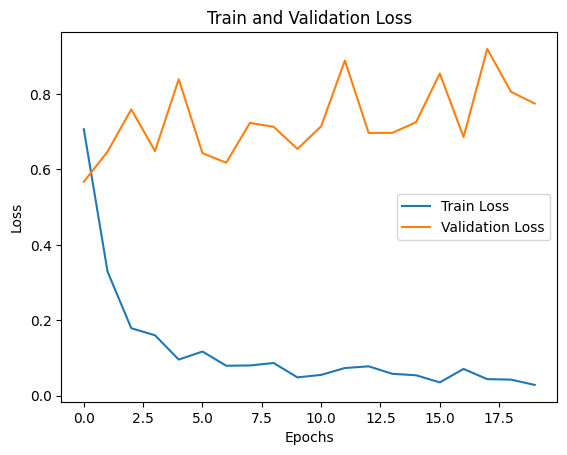

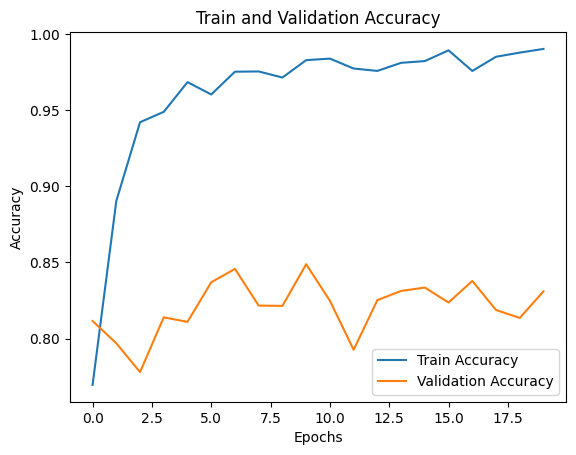

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

Model VGG19


In [ ]:
class MyVGG16(nn.Module):
    def __init__(self):
        super(MyVGG16, self).__init__()
        # The VGG16 architecture consists of convolutional layers followed by fully connected layers.
        # Here, we define the VGG16 layers and initialize them.

        # Convolutional layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 64 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # 64 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling with kernel_size=2, stride=2

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 128 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # 128 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling with kernel_size=2, stride=2

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # 256 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling with kernel_size=2, stride=2

            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Max pooling with kernel_size=2, stride=2

            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # 512 filters, kernel_size=3, padding=1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Max pooling with kernel_size=2, stride=2
        )

        # Fully connected layers
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # Adaptive average pooling to output size 7x7
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),  # Fully connected layer with 512*7*7 input features and 4096 output features
            nn.ReLU(inplace=True),
            nn.Dropout(),  # Dropout layer for regularization
            nn.Linear(4096, 4096),  # Fully connected layer with 4096 input features and 4096 output features
            nn.ReLU(inplace=True),
            nn.Dropout(),  # Dropout layer for regularization
            nn.Linear(4096, 11)  # Output layer with 4096 input features and 11 output features (classes)
        )

    def forward(self, x):
        # Forward pass through the network
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the feature maps
        x = self.classifier(x)
        return x


In [ ]:
# # Check if CUDA (GPU) is available and define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create an instance of the MyVGG16 model
VGG_model = MyVGG16()
# Create an instance of the MyVGG18 model
VGG_model.to(device)


MyVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(VGG_model.parameters(), lr=0.0003)

In [ ]:
# Load pretrained VGG16 model
VGG_model = models.vgg16(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_ftrs = VGG_model.classifier[6].in_features
VGG_model.classifier[6] = nn.Linear(num_ftrs, 11)  # Assuming there are 11 classes

# Check if CUDA (GPU) is available and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the VGG16 model
VGG_model.to(device)

# Define loss function and optimizer with a learning rate of 0.0003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG_model.parameters(), lr=0.0003)

# Number of training epochs
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    VGG_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = VGG_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    VGG_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = VGG_model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(VGG_model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 108MB/s]


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 001/020] Train: loss=1.58322, acc=0.45651 | Valid: loss=0.99138, acc=0.66792


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 002/020] Train: loss=0.94320, acc=0.69333 | Valid: loss=0.84252, acc=0.73052


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 003/020] Train: loss=0.70915, acc=0.77259 | Valid: loss=0.86301, acc=0.72415


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 004/020] Train: loss=0.59594, acc=0.81278 | Valid: loss=0.76615, acc=0.76784


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 005/020] Train: loss=0.46014, acc=0.85827 | Valid: loss=0.71182, acc=0.77045


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 006/020] Train: loss=0.36726, acc=0.88418 | Valid: loss=0.76839, acc=0.78492


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 007/020] Train: loss=0.29010, acc=0.90837 | Valid: loss=0.75237, acc=0.79726


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 008/020] Train: loss=0.27491, acc=0.91347 | Valid: loss=0.82494, acc=0.77459


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 009/020] Train: loss=0.22424, acc=0.93062 | Valid: loss=0.83472, acc=0.78347


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 010/020] Train: loss=0.19688, acc=0.93780 | Valid: loss=0.95366, acc=0.74190


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 011/020] Train: loss=0.24924, acc=0.92627 | Valid: loss=0.81254, acc=0.78791


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 012/020] Train: loss=0.12511, acc=0.96268 | Valid: loss=0.98508, acc=0.77836


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 013/020] Train: loss=0.13940, acc=0.95752 | Valid: loss=1.20563, acc=0.76186


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 014/020] Train: loss=0.21619, acc=0.93716 | Valid: loss=0.98499, acc=0.75579


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 015/020] Train: loss=0.14759, acc=0.95540 | Valid: loss=1.05916, acc=0.76688


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 016/020] Train: loss=0.11707, acc=0.96501 | Valid: loss=1.02553, acc=0.78598


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 017/020] Train: loss=0.10907, acc=0.96600 | Valid: loss=0.87322, acc=0.79562


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 018/020] Train: loss=0.13919, acc=0.96106 | Valid: loss=1.10818, acc=0.76881


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 019/020] Train: loss=0.09854, acc=0.96954 | Valid: loss=1.18007, acc=0.77623


  0%|          | 0/309 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

[Epoch: 020/020] Train: loss=0.08820, acc=0.97439 | Valid: loss=1.20600, acc=0.79070


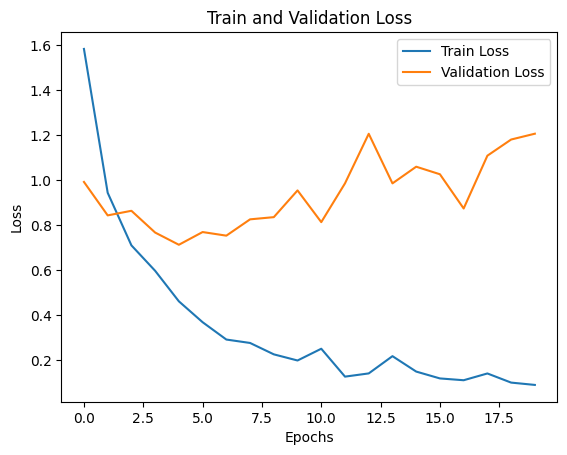

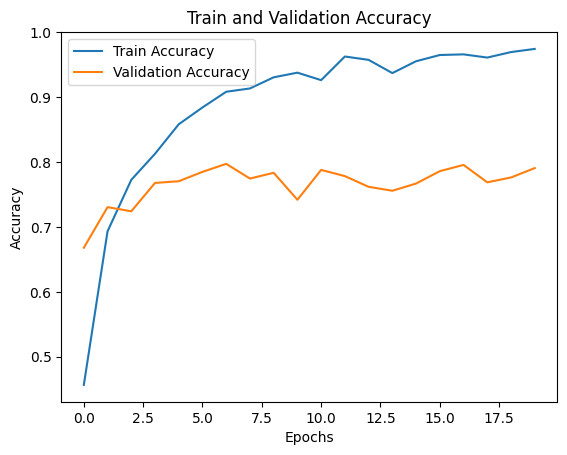

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

Model - DENSENET


In [9]:
class MyDenseNet(nn.Module):
    def __init__(self):
        super(MyDenseNet, self).__init__()
        # Load pre-trained DenseNet model
        densenet121 = models.densenet121(pretrained=True)

        # Remove the final fully connected layer from DenseNet121
        self.features = nn.Sequential(*list(densenet121.children())[:-1])

        # Define additional fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(1024, 256),  # Adjust the input size based on the output size of DenseNet121
            nn.ReLU(),
            nn.Linear(256, 11)     # Output size 11 for classification
        )

    def forward(self, x):
        # input (x): [batch_size, 3, 224, 224]
        # output: [batch_size, 11] for 11 classes

        # Extract features using DenseNet121
        x = self.features(x)

        # Flatten the extracted features
        x = torch.flatten(x, 1)

        # Pass through additional fully connected layers
        x = self.fc_layers(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm

# Load pretrained DenseNet model
DenseNet_model = models.densenet121(pretrained=True)

# Modify the last fully connected layer to match the number of classes in your dataset
num_ftrs = DenseNet_model.classifier.in_features
DenseNet_model.classifier = nn.Linear(num_ftrs, 11)  # Assuming there are 11 classes

# Check if CUDA (GPU) is available and define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create an instance of the DenseNet model
DenseNet_model.to(device)

# Define loss function and optimizer with a learning rate of 0.0003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(DenseNet_model.parameters(), lr=0.0003)

# Number of training epochs
n_epochs = 20

# These are used to record information
best_valid_acc = 0
train_loss_epochs = []
train_acc_epochs = []
valid_loss_epochs = []
valid_acc_epochs = []

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    DenseNet_model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    # Iterate the training set by batches.
    for batch in tqdm(train_loader):

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = DenseNet_model(imgs)

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)

        # Compute the gradients for parameters.
        loss.backward()

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc.item())

    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_loss_epochs.append(train_loss)
    train_acc_epochs.append(train_acc)

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    DenseNet_model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = DenseNet_model(imgs)

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels)

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc.item())

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    valid_loss_epochs.append(valid_loss)
    valid_acc_epochs.append(valid_acc)

    # save the best model
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        torch.save(DenseNet_model.state_dict(), 'best_model.pth')

    # Print the information.
    print(f"[Epoch: {epoch + 1:03d}/{n_epochs:03d}] Train: loss={train_loss:.5f}, acc={train_acc:.5f} | Valid: loss={valid_loss:.5f}, acc={valid_acc:.5f}")


100%|██████████| 108/108 [01:18<00:00,  1.37it/s]


[Epoch: 001/020] Train: loss=0.68520, acc=0.77797 | Valid: loss=0.57554, acc=0.80768


100%|██████████| 108/108 [01:22<00:00,  1.31it/s]


[Epoch: 002/020] Train: loss=0.38460, acc=0.87476 | Valid: loss=0.47250, acc=0.85272


100%|██████████| 108/108 [01:22<00:00,  1.30it/s]


[Epoch: 003/020] Train: loss=0.29530, acc=0.90370 | Valid: loss=0.55268, acc=0.82022


100%|██████████| 108/108 [01:24<00:00,  1.28it/s]


[Epoch: 004/020] Train: loss=0.25276, acc=0.91622 | Valid: loss=0.48334, acc=0.85523


100%|██████████| 108/108 [01:21<00:00,  1.32it/s]


[Epoch: 005/020] Train: loss=0.22294, acc=0.92385 | Valid: loss=0.44017, acc=0.86719


100%|██████████| 108/108 [01:18<00:00,  1.37it/s]


[Epoch: 006/020] Train: loss=0.17133, acc=0.94478 | Valid: loss=0.50237, acc=0.85002


100%|██████████| 108/108 [01:23<00:00,  1.29it/s]


[Epoch: 007/020] Train: loss=0.15921, acc=0.94555 | Valid: loss=0.39786, acc=0.87789


 20%|██        | 63/309 [00:56<03:46,  1.09it/s]

In [ ]:
# Plotting the loss curves
plt.figure()
plt.plot(train_loss_epochs, label='Train Loss')
plt.plot(valid_loss_epochs, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy curves
plt.figure()
plt.plot(train_acc_epochs, label='Train Accuracy')
plt.plot(valid_acc_epochs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Load best model weights
DenseNet_model.load_state_dict(torch.load('best_model.pth'))

# Make sure the model is in eval mode.
# Some modules like Dropout or BatchNorm affect if the model is in training mode.
DenseNet_model.eval()

test_accs = []

# Iterate the testing set by batches.
for batch in tqdm(test_loader):
    # A batch consists of image data and corresponding labels.
    imgs, labels = batch
    imgs = imgs.to(device)
    labels = labels.to(device)

    # We don't need gradient in test
    # Using torch.no_grad() accelerates the forward process.
    with torch.no_grad():
      logits = DenseNet_model(imgs)

    # We can still compute the loss (but not the gradient).
    loss = criterion(logits, labels)

    # Compute the accuracy for current batch.
    acc = (logits.argmax(dim=-1) == labels).float().mean()

    # Record accuracy.
    test_accs.append(acc)

# The average accuracy for entire test set is the average of the recorded values.
test_acc = sum(test_accs) / len(test_accs)
print(f'Test accuracy {test_acc}')
